In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import scipy as sp
import json

In [2]:
import plot_utils
import stats_utils

In [3]:
model_identifier = 'gpt2-xl'

In [4]:
savedir = "results_paper_revision/correlations2brainscore"
if not os.path.exists(savedir):
    os.makedirs(savedir, exist_ok=True)

In [5]:
#load configuration
with open('configurations.json', 'r') as f:
    config = json.load(f)

In [6]:
# get setting
approach = "TrainIntact-TestPerturbed:contextualized"

emb_context=config[approach]["emb_context"]
split_coord=config[approach]["split_coord"]
testonperturbed=config[approach]["testonperturbed"]

# Load activations dictionary

In [7]:
with open(os.path.abspath(f"model_activation_dictionary,model={model_identifier},emb_context={emb_context},lasttoken.pkl"), "rb") as f:
    activations_dictionary = pickle.load(f)

In [8]:
randomnouns = False
if not randomnouns:
    activations_dictionary = {k:v for k,v in activations_dictionary.items() if k != "random-nouns"}

In [9]:
# check dictionary content
print(activations_dictionary.keys())
print(activations_dictionary['Original'].keys())

dict_keys(['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'backward', 'chatgpt', 'concatenated-control', 'contentwords', 'functionwords', 'length-control', 'lowPMI', 'lowPMI-random', 'nouns', 'nounsverbs', 'nounsverbsadj', 'random-wl', 'sentenceshuffle_passage', 'sentenceshuffle_random', 'sentenceshuffle_topic'])
dict_keys(['243sentences01', '243sentences10', '243sentences11', '243sentences12', '243sentences13', '243sentences14', '243sentences15', '243sentences16', '243sentences17', '243sentences18', '243sentences19', '243sentences02', '243sentences20', '243sentences21', '243sentences22', '243sentences23', '243sentences24', '243sentences25', '243sentences26', '243sentences27', '243sentences28', '243sentences29', '243sentences03', '243sentences30', '243sentences31', '243sentences32', '243sentences33', '243sentences34', '243sentences35', '243sentences36', '243sentences37', '243sentences38', '243sentences39', '243sentences04', '243sentences40', '243sentences41', '243sentences42', '243sentenc

In [10]:
def get_nlayers():
    for key in activations_dictionary.keys():
        for passage_id in activations_dictionary[key].keys():
            nlayers = np.shape(activations_dictionary[key][passage_id])[0]
            print(nlayers)
            break
        break
    return nlayers

# Get correlations

In [11]:
from scipy import stats
from tqdm import tqdm

if os.path.isfile('activation_spearman_correlations.pkl'):
    print("Loading activations correlations dict from cache!")
    with open('activation_spearman_correlations.pkl', 'rb') as handle:
        correlations_dict = pickle.load(handle) 

else:
    print("Generating activations correlations dict!")

    #want: 1 list of correlations per condition, 49 values for each layer
    nlayers = get_nlayers()

    correlations_dict = {}

    for cond in activations_dictionary.keys():
        print(f"Original vs. {cond}")
        condition_correlations = []

        for layer in tqdm(range(nlayers)):
            layer_correlations = []

            for passage_id in list(activations_dictionary['Original'].keys()):
                n_sentences_in_passage = np.shape(activations_dictionary['Original'][passage_id])[1]

                for sentence_ind in range(n_sentences_in_passage):
                    original_act = activations_dictionary['Original'][passage_id][layer][sentence_ind]
                    cond_act = activations_dictionary[cond][passage_id][layer][sentence_ind]
                    corr = stats.spearmanr(original_act,cond_act)[0]
                    layer_correlations.append(corr)

            avg_correlation_for_layer = np.mean(layer_correlations)
            condition_correlations.append(avg_correlation_for_layer)

        correlations_dict[cond] = condition_correlations
    
    with open('activation_spearman_correlations.pkl', 'wb') as handle:
        pickle.dump(correlations_dict, handle) 

Loading activations correlations dict from cache!


In [12]:
correlations_dict

{'Original': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'Scr1': [1.0,
  0.9996634643314652,
  0.9996431029101154,
  0.9995415787367407,
  0.9992981889768633,
  0.9988119173270659,
  0.998291661719985,
  0.9971012139284983,
  0.9959780923014493,
  0.9934960678873137,
  0.9880123636267729,
  0.9827823930279677,
  0.9749134350738361,
  0.9617733049603462,
  0.949035925472779,
  0.9322615768129976,
  0.9160763346739301,
  0.9069452192662304,
  0.9001023897964535,
  0.8941581313550867,
  0.8895736696575566,
  0.8886182450991051,
  0.886399145614769,
  0.8956741643155934,
  0.9037300252117583,
  0.9064764532272739,
  0.9114446839674178,
  0.9145342777376494,
  0.9155494122277109,
  0.916335664522

In [13]:
correlations_dict = {k:v for k,v in correlations_dict.items() if not "-control" in k}

In [14]:
correlations_dict.keys()

dict_keys(['Original', 'Scr1', 'Scr3', 'Scr5', 'Scr7', 'backward', 'chatgpt', 'contentwords', 'functionwords', 'lowPMI', 'lowPMI-random', 'nouns', 'nounsverbs', 'nounsverbsadj', 'random-wl', 'sentenceshuffle_passage', 'sentenceshuffle_random', 'sentenceshuffle_topic'])

In [15]:
#assimilate names between activations and brainscores
if testonperturbed:
    to_prepend = "teston:"
else:
    to_prepend = ""

CONDMAP = {
'Original' : f'{to_prepend}original',
    #
'Scr1' : f'{to_prepend}scrambled1', #different for teston, there teston:scr1
'Scr3' : f'{to_prepend}scrambled3',
'Scr5' : f'{to_prepend}scrambled5',
'Scr7' : f'{to_prepend}scrambled7',
'backward' : f'{to_prepend}backward',
'lowPMI' : f'{to_prepend}lowpmi',
'lowPMI-random' : f'{to_prepend}lowpmi-random',
#
'nouns' : f'{to_prepend}nouns',
'randomnouns' : f'{to_prepend}random-nouns',
'nounsverbs' : f'{to_prepend}nounsverbs',
'nounsverbsadj' : f'{to_prepend}nounsverbsadj',
'contentwords' : f'{to_prepend}contentwords',
'functionwords' : f'{to_prepend}functionwords',
 #
'chatgpt' : f'{to_prepend}chatgpt',
'sentenceshuffle_passage' : f'{to_prepend}sent_passage',
'sentenceshuffle_topic' : f'{to_prepend}sent_topic',
'sentenceshuffle_random' : f'{to_prepend}sent_random',
#
'random-wl' : f'{to_prepend}random-wl'
}

In [16]:
if testonperturbed:
    for key, value in CONDMAP.items():
        CONDMAP[key] = re.sub("scrambled","scr",value)

In [17]:
correlations_df = pd.DataFrame.from_dict(correlations_dict)
correlations_df = correlations_df.rename(columns={col:CONDMAP[col] for col in correlations_df.columns})

_, COND2CAT = plot_utils.get_conditions(testonperturbed=testonperturbed, randomnouns=randomnouns)
print(list(COND2CAT.keys()))
condition_order = [re.sub("enceshuffle","",elm) for elm in list(COND2CAT.keys())]

correlations_df = correlations_df[condition_order]

['teston:original', 'teston:scr1', 'teston:scr3', 'teston:scr5', 'teston:scr7', 'teston:backward', 'teston:lowpmi', 'teston:lowpmi-random', 'teston:contentwords', 'teston:nounsverbsadj', 'teston:nounsverbs', 'teston:nouns', 'teston:functionwords', 'teston:chatgpt', 'teston:sentenceshuffle_passage', 'teston:sentenceshuffle_topic', 'teston:sentenceshuffle_random', 'teston:random-wl']


In [18]:
correlations_df

,teston:original,teston:scr1,teston:scr3,teston:scr5,teston:scr7,teston:backward,teston:lowpmi,teston:lowpmi-random,teston:contentwords,teston:nounsverbsadj,teston:nounsverbs,teston:nouns,teston:functionwords,teston:chatgpt,teston:sent_passage,teston:sent_topic,teston:sent_random,teston:random-wl
0,1.0,1.000000,0.986874,0.985474,0.986874,0.978901,0.988151,0.984920,0.938280,0.932675,0.911390,0.865850,0.846682,0.974153,0.972914,0.964172,0.963043,0.972423
1,1.0,0.999663,0.987574,0.986324,0.987092,0.971920,0.987194,0.982047,0.940907,0.929380,0.894540,0.792079,0.639349,0.956285,0.930482,0.887778,0.858425,0.873879
2,1.0,0.999643,0.986943,0.985615,0.986071,0.967848,0.984595,0.978977,0.932704,0.922016,0.889804,0.778192,0.616473,0.958563,0.930832,0.881608,0.842868,0.844760
3,1.0,0.999542,0.988084,0.986665,0.986756,0.962304,0.983104,0.975934,0.927188,0.915945,0.884253,0.767542,0.609382,0.955295,0.924257,0.875798,0.832744,0.830759
4,1.0,0.999298,0.988282,0.986582,0.986095,0.953178,0.980049,0.970072,0.925272,0.913200,0.881579,0.756155,0.580812,0.950331,0.916163,0.867534,0.822456,0.816311
5,1.0,0.998812,0.988292,0.986060,0.984650,0.941218,0.976189,0.961200,0.925135,0.912554,0.881263,0.750634,0.551849,0.948233,0.907208,0.860496,0.814810,0.802925
6,1.0,0.998292,0.984322,0.981403,0.979355,0.931653,0.972462,0.953134,0.918994,0.904341,0.870664,0.732713,0.502504,0.941919,0.895094,0.844864,0.793701,0.776799
7,1.0,0.997101,0.977374,0.973092,0.969660,0.911212,0.965198,0.937427,0.914496,0.898656,0.864373,0.719083,0.466951,0.934607,0.880350,0.828582,0.773576,0.748545
8,1.0,0.995978,0.969797,0.964384,0.959360,0.892995,0.959488,0.923838,0.911902,0.894762,0.859432,0.709027,0.440404,0.929720,0.867137,0.815678,0.758349,0.725230
9,1.0,0.993496,0.966753,0.959423,0.950854,0.867771,0.951708,0.905844,0.904811,0.886135,0.849808,0.693779,0.405279,0.925181,0.857956,0.804875,0.745798,0.694782


# Load brain scores

In [19]:
#TODO adapt function in plot_utils.py to output either best or all scores

def get_scores_dictionary(model_identifier, emb_context, split_coord, testonperturbed, randomnouns):
    """
    input: model_identifier, embedding context, split_coordinate & whether to test on perturbed sentence
    output: dataframe containing the maximum score and associated error per condition.
    """
    
    print_cnt = 0
    
    score_dict = {}
    scores_dir = "/om2/user/ckauf/.result_caching/neural_nlp.score"
    
    CAT2COND, COND2CAT = plot_utils.get_conditions(testonperturbed=testonperturbed, randomnouns=randomnouns)
    
    for filename in os.listdir(scores_dir):
        
        if os.path.isdir(os.path.join(scores_dir,filename)):
            continue
            
        if not testonperturbed:
            if "teston:" in filename:
                continue
        else:
            if not "teston:" in filename:
                continue
                
        if not f"emb_context={emb_context}" in filename:
            continue
                
        if not f"split_coord={split_coord}" in filename:
            continue
        
        exclude_list = ["-control", "random-nouns"]
        if randomnouns:
            exclude_list = ["-control"]
            
        if any(x in filename for x in exclude_list):
            continue
                        

        model_name = filename.split(",")[1]
        bm = filename.split(",")[0]
        
        if bm == "benchmark=Pereira2018-encoding": #exclude old orignial bm in different format
            continue
        
        if "model=" + model_identifier == model_name:
            
            print_cnt += 1
            
            condition = bm.split("benchmark=Pereira2018-encoding-")[-1]
            
            #clean name
            condition = re.sub("perturb-","",condition)
            if not any(x in condition for x in ["1", "3", "5", "7"]):
                condition = re.sub("scrambled-","",condition)
            
            if testonperturbed:
                condition = re.sub("scrambled","scr",condition)

            #load scores
            file = os.path.join(scores_dir,filename)
            with open(file, 'rb') as f:
                out = pickle.load(f)

            # Get dictionary of subject scores by layer (unnormalized)
            scores, errors = [], []
            frames = []
            result = out['data']
            for l in result.raw.raw.layer.data:
                subject_scores = []
                layerwise_scores = result.raw.raw.sel(layer=l)
                subject_score = layerwise_scores.groupby('subject').median()
                df = pd.DataFrame({
                'subject_id' : subject_score.subject,
                'subject_score' : subject_score,
                'layer' : [l] * len(subject_score)
                })
                frames.append(df)
            raw_brainscore_df = pd.concat(frames)
            # per voxel, get median per layer per subject
            brainscore_df = raw_brainscore_df.groupby(['subject_id', 'layer']).median().reset_index()

            brainscore_df_with_medians = brainscore_df.copy(deep=True)
            for l in result.raw.raw.layer.data:
                # get median over subjects
                score = brainscore_df_with_medians.loc[brainscore_df_with_medians['layer'] == l]['subject_score'].median()
                subject_scores = list(brainscore_df_with_medians.loc[brainscore_df_with_medians['layer'] == l]['subject_score'])
                error = stats.median_abs_deviation(subject_scores, scale='normal')
                scores.append(score)
                errors.append(error)

            
            score_dict[condition] = {}
            score_dict[condition]["score"] = scores
            score_dict[condition]["error"] = errors
    
    return score_dict

In [20]:
score_dict = get_scores_dictionary(model_identifier=model_identifier, emb_context=emb_context,
             split_coord=split_coord, testonperturbed=testonperturbed, randomnouns=randomnouns)

In [21]:
score_dict.keys()

dict_keys(['teston:backward', 'teston:chatgpt', 'teston:contentwords', 'teston:functionwords', 'teston:lowpmi', 'teston:lowpmi-random', 'teston:nouns', 'teston:nounsverbs', 'teston:nounsverbsadj', 'teston:original', 'teston:random-wl', 'teston:scr1', 'teston:scr3', 'teston:scr5', 'teston:scr7', 'teston:sentenceshuffle_passage', 'teston:sentenceshuffle_random', 'teston:sentenceshuffle_topic'])

In [22]:
scores_only = {k: score_dict[k]["score"] for k in list(score_dict.keys())}

df = pd.DataFrame.from_dict(scores_only)

_, COND2CAT = plot_utils.get_conditions(testonperturbed=testonperturbed, randomnouns=randomnouns)
condition_order = list(COND2CAT.keys())
df = df[condition_order]
df = df.rename(columns={col:re.sub("enceshuffle","",col) for col in df.columns})
df

,teston:original,teston:scr1,teston:scr3,teston:scr5,teston:scr7,teston:backward,teston:lowpmi,teston:lowpmi-random,teston:contentwords,teston:nounsverbsadj,teston:nounsverbs,teston:nouns,teston:functionwords,teston:chatgpt,teston:sent_passage,teston:sent_topic,teston:sent_random,teston:random-wl
0,-0.001301,-0.001301,0.004187,0.001657,0.004187,-0.004798,0.005523,0.000281,0.000070,0.003879,-0.002114,0.003135,-0.005223,-0.007219,0.000858,-0.004120,-0.000277,-0.000109
1,0.301456,0.302099,0.274933,0.267993,0.269851,0.247145,0.286129,0.265106,0.259481,0.250737,0.227653,0.176867,0.049609,0.217113,0.265258,0.087717,0.005211,0.019104
2,0.311925,0.313072,0.281987,0.276630,0.280469,0.250009,0.293438,0.275196,0.269471,0.254041,0.238050,0.171366,0.046029,0.215744,0.273467,0.085887,0.005676,0.019216
3,0.317048,0.315966,0.294472,0.289114,0.291322,0.266030,0.297291,0.283275,0.275087,0.262191,0.245513,0.183039,0.059216,0.231293,0.281961,0.091134,-0.005782,0.019827
4,0.310072,0.307426,0.288514,0.285437,0.288485,0.263587,0.287265,0.279865,0.265612,0.254347,0.236736,0.179416,0.042567,0.223344,0.274848,0.079086,0.002656,0.034631
5,0.297491,0.290244,0.270020,0.267734,0.266983,0.240401,0.275983,0.263719,0.247071,0.241025,0.217980,0.164960,0.039318,0.221746,0.263380,0.079273,-0.004198,0.021763
6,0.288814,0.282315,0.259970,0.256394,0.259152,0.229831,0.264666,0.244402,0.235519,0.226244,0.208952,0.155852,0.037952,0.221652,0.255355,0.081542,-0.003454,0.015523
7,0.287373,0.283326,0.255262,0.251611,0.247991,0.214335,0.265734,0.221542,0.233123,0.224134,0.200062,0.153949,0.026657,0.207652,0.244704,0.077890,-0.005956,0.018396
8,0.282742,0.279773,0.247810,0.244257,0.244504,0.203932,0.250094,0.216280,0.230721,0.215770,0.191553,0.146238,0.030917,0.211517,0.245189,0.076632,-0.011966,0.023058
9,0.274139,0.266268,0.244090,0.239453,0.237210,0.185229,0.248512,0.203452,0.235223,0.212114,0.200622,0.142342,0.029356,0.203960,0.236355,0.070636,-0.023088,0.026766


In [23]:
assert all(df.columns == correlations_df.columns)
print("Same columns")

Same columns


# Plotting

## Merge dataframes

In [24]:
long_brainscores = pd.melt(df)
long_brainscores = long_brainscores.rename(columns={"value":f"brainscore"})
long_brainscores["index"] = long_brainscores.index
long_brainscores

,variable,brainscore,index
0,teston:original,-0.001301,0
1,teston:original,0.301456,1
2,teston:original,0.311925,2
3,teston:original,0.317048,3
4,teston:original,0.310072,4
...,...,...,...
877,teston:random-wl,0.007408,877
878,teston:random-wl,0.006957,878
879,teston:random-wl,0.010726,879
880,teston:random-wl,0.007790,880


In [25]:
long_correlations = pd.melt(correlations_df)
long_correlations = long_correlations.rename(columns={"value":f"correlation"})
long_correlations["index"] = long_correlations.index
long_correlations

,variable,correlation,index
0,teston:original,1.000000,0
1,teston:original,1.000000,1
2,teston:original,1.000000,2
3,teston:original,1.000000,3
4,teston:original,1.000000,4
...,...,...,...
877,teston:random-wl,0.371249,877
878,teston:random-wl,0.374949,878
879,teston:random-wl,0.380441,879
880,teston:random-wl,0.378024,880


In [26]:
plot_df = pd.merge(long_brainscores, long_correlations, how='inner', on='index')
# plot_df = plot_df.drop(["variable_y"])
plot_df = plot_df.rename(columns={"variable_x":"condition"})

#add layer indices
nlayers = len(plot_df.loc[plot_df["condition"]==f"{to_prepend}original"])
nconds = len(list(plot_df["condition"].unique()))
layers = list(range(nlayers)) * nconds
plot_df["layer"] = layers

plot_df = plot_df[["index","condition","brainscore","correlation", "layer"]]
plot_df

,index,condition,brainscore,correlation,layer
0,0,teston:original,-0.001301,1.000000,0
1,1,teston:original,0.301456,1.000000,1
2,2,teston:original,0.311925,1.000000,2
3,3,teston:original,0.317048,1.000000,3
4,4,teston:original,0.310072,1.000000,4
...,...,...,...,...,...
877,877,teston:random-wl,0.007408,0.371249,44
878,878,teston:random-wl,0.006957,0.374949,45
879,879,teston:random-wl,0.010726,0.380441,46
880,880,teston:random-wl,0.007790,0.378024,47


In [27]:
CAT2COND, COND2CAT = plot_utils.get_conditions()

In [28]:
# rename conditions according to new names:
if testonperturbed:
    plot_df['condition'] = [re.sub("teston:","",elm) for elm in list(plot_df['condition'])]
    plot_df['condition'] = [re.sub("scr","scrambled",elm) for elm in list(plot_df['condition'])]   
print(plot_df)
plot_df['category'] = plot_df['condition'].map(COND2CAT)
plot_df = plot_df.fillna("semantic-distance")
print(plot_df['category'].unique())
plot_df['condition'] = plot_df['condition'].map(plot_utils.COND2LABEL)
plot_df

     index  condition  brainscore  correlation  layer
0        0   original   -0.001301     1.000000      0
1        1   original    0.301456     1.000000      1
2        2   original    0.311925     1.000000      2
3        3   original    0.317048     1.000000      3
4        4   original    0.310072     1.000000      4
..     ...        ...         ...          ...    ...
877    877  random-wl    0.007408     0.371249     44
878    878  random-wl    0.006957     0.374949     45
879    879  random-wl    0.010726     0.380441     46
880    880  random-wl    0.007790     0.378024     47
881    881  random-wl    0.010896     0.391708     48

[882 rows x 5 columns]
['original' 'word-order' 'information-loss' 'semantic-distance' 'control']


,index,condition,brainscore,correlation,layer,category
0,0,Original,-0.001301,1.000000,0,original
1,1,Original,0.301456,1.000000,1,original
2,2,Original,0.311925,1.000000,2,original
3,3,Original,0.317048,1.000000,3,original
4,4,Original,0.310072,1.000000,4,original
...,...,...,...,...,...,...
877,877,RandWordList,0.007408,0.371249,44,control
878,878,RandWordList,0.006957,0.374949,45,control
879,879,RandWordList,0.010726,0.380441,46,control
880,880,RandWordList,0.007790,0.378024,47,control


In [29]:
f"Correlation: {plot_df['brainscore'].corr(plot_df['correlation'])}"

'Correlation: 0.7215446661644643'

## Scatter plot

In [30]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

custom_params = {"axes.spines.right": False,
                 "axes.spines.top": False,
                 'ytick.left': True,
                 'xtick.bottom': True,
                'grid.linestyle': "", #gets rid of horizontal lines
                 # set tick width
                'xtick.major.size' : 20,
                'xtick.major.width': 4,
                'xtick.minor.size' : 10,
                'xtick.minor.width' : 2,
                'ytick.major.size' : 20,
                'ytick.major.width': 4,
                'ytick.minor.size' : 10,
                'ytick.minor.width' : 2
                }
sns.set_theme(font_scale=2, style="white", rc=custom_params)

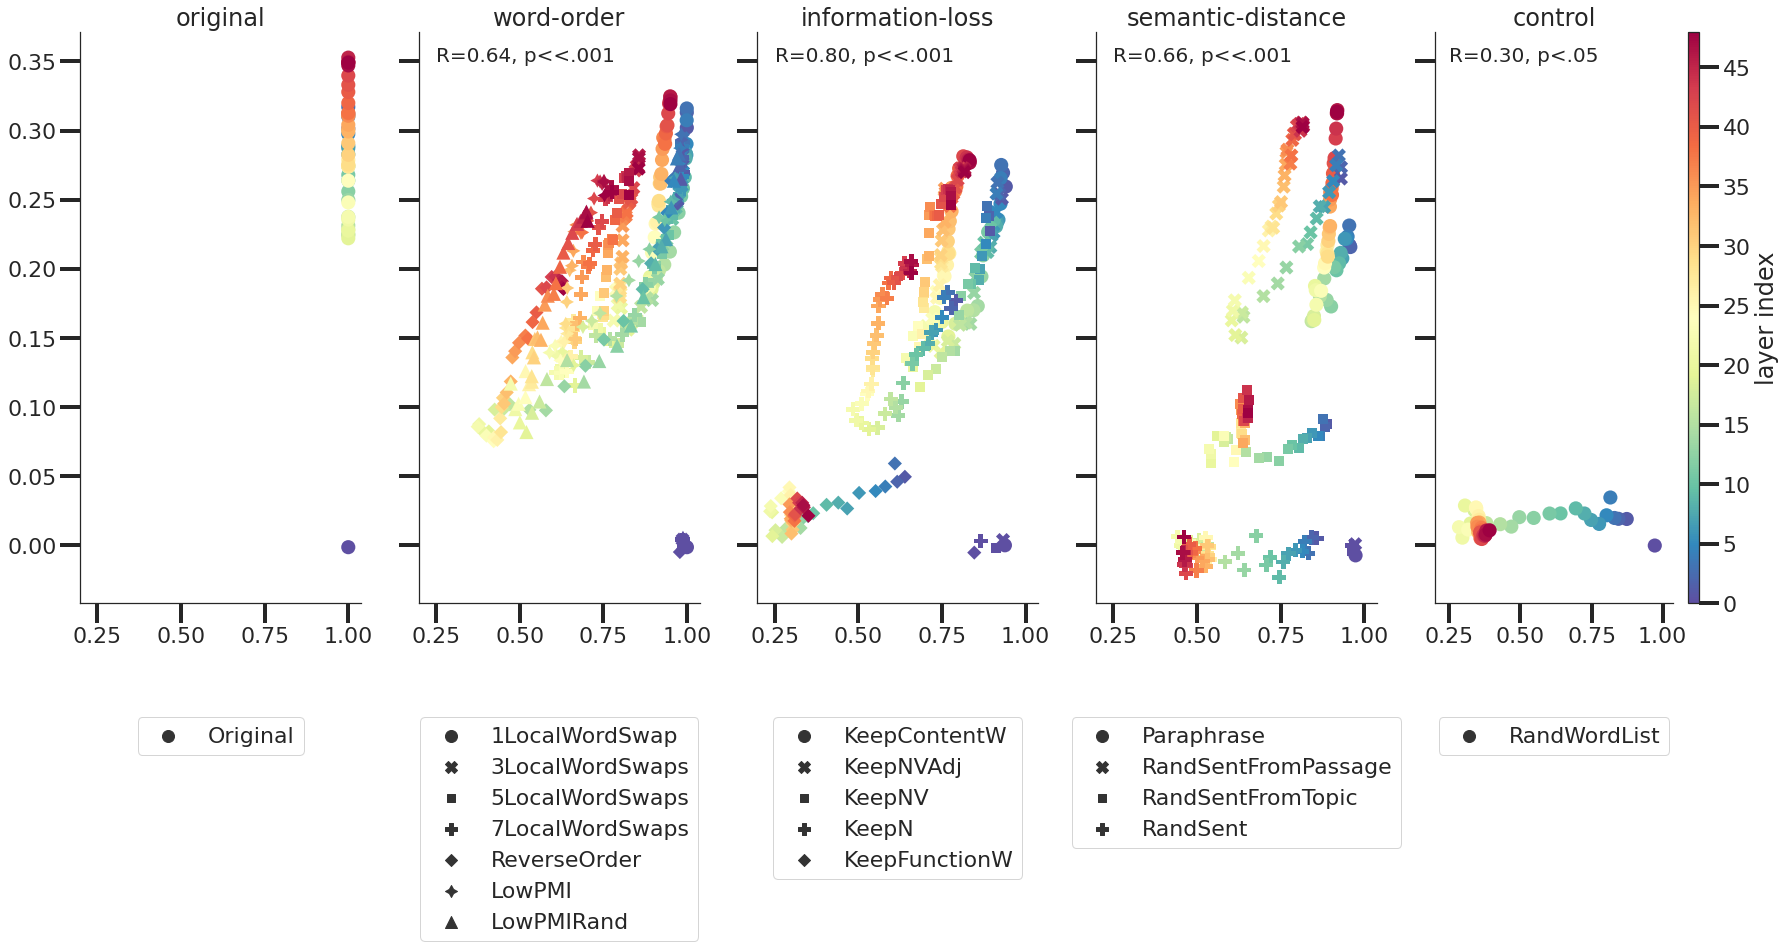

In [31]:
# Create a FacetGrid object with a row for each unique value of the hue variable
g = sns.FacetGrid(data = plot_df, col="category", height=10, aspect=0.5, margin_titles=True)

mypalette = "Spectral_r"

# Use the scatterplot function to draw a scatterplot on each subplot
g.map_dataframe(sns.scatterplot, x="correlation", y="brainscore", hue="layer", style="condition", palette=mypalette,
                         edgecolor="none", s=200, legend="auto")
#g.map_dataframe(sns.regplot, x="correlation", y="brainscore", scatter=False)
g.set_titles(col_template="{col_name}")

norm = plt.Normalize(plot_df['layer'].min(), plot_df['layer'].max())
sm = plt.cm.ScalarMappable(cmap=mypalette, norm=norm)
sm.set_array([])  

len_layers = len(plot_df["layer"].unique())

num_axes = len(g.axes[0])

# Put a legend below current axis (only for styles)
for ind, ax in enumerate(g.axes[0]):
    handles, labels = ax.get_legend_handles_labels()
    handles_labels = list(zip(handles, labels))

    handles_labels = [elm for elm in handles_labels if not elm[1].isdigit()]
    handles_labels = [elm for elm in handles_labels if elm[1] not in ["condition", "layer"]]
    handles = [elm[0] for elm in handles_labels]
    labels = [elm[1] for elm in handles_labels]
    
    ax.set(xlabel="", ylabel='')

    ax.legend(handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, -0.18),
          fancybox=True, shadow=False, ncol=1, markerscale=2,
          title_fontsize=25)
    
    if ind == num_axes - 1:
        bar = plt.colorbar(sm, ticks=list(range(len_layers))[::5], aspect=50, orientation='vertical', ax=ax, label='layer index',
                      fraction=0.1)
        
    #add stats
    sub_df = plot_df.loc[plot_df["category"] == ax.get_title()]
    r, p = sp.stats.pearsonr(sub_df['correlation'], sub_df['brainscore'])
    
    if p < 0.0001:
        p_text = "p<<.001"
    elif p < 0.001:
        p_text = "p<.001"
    elif p < 0.01:
        p_text = "p<.01"
    elif p < 0.05:
        p_text = "p<.05"
    else:
        p_text = "p={:.2g}, n.s.".format(p)

    if ind != 0:
        ax.text(0.25, 0.35,'R={:.2f}, {}'.format(r, p_text), fontsize=20)#,
                 #horizontalalignment='right', color='black', fontsize=30)
            
savename = f'{savedir}/correlation2bs,approach={approach}_Faceted'

plt.savefig(f'{savename}.svg', dpi=180, bbox_inches='tight')
plt.savefig(f'{savename}.png', dpi=180, bbox_inches='tight')
plt.show()

# Plot brain predictivity performance by layers

In [41]:
import math
from matplotlib.gridspec import GridSpec

def get_lineplots_loop(error_shading=True):
    sns.set_theme(font_scale=1.5, style="white", rc=custom_params)
    CAT2COND, COND2CAT = plot_utils.get_conditions(testonperturbed=testonperturbed, randomnouns=randomnouns)
    layers = stats_utils.get_all_layers(model_identifier)
    layers[0] = "embedding"
    score_dict = get_scores_dictionary(model_identifier=model_identifier,
                                        emb_context=emb_context,
                                        split_coord=split_coord,
                                         testonperturbed=testonperturbed,
                                         randomnouns=randomnouns)
    
    if testonperturbed:
        to_prepend = "teston:"
    else:
        to_prepend = ""
    
    #define colors
    CAT2COLOR = {
        f"{to_prepend}original": "dimgray",
        #
        "word-order": sns.cubehelix_palette(7, start=.2, rot=-.25, dark=0.2, light=.9, reverse=True),
        "information-loss": sns.cubehelix_palette(5, start=2, rot=0, dark=0.2, light=.85, reverse=True),
        #cut off as last gradient color is similar across colors
        "semantic-distance": sns.light_palette("maroon", 5, reverse=True)[:4],
        #
        "control": "lightgray"
    }

    if randomnouns:
        CAT2COLOR["information-loss"] = sns.cubehelix_palette(6, start=2, rot=0, dark=0.2, light=.85, reverse=True)

    nsubplots = len(CAT2COND.keys())
    nrows = math.ceil(nsubplots/2)
    line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d") + sns.color_palette("PRGn", 10) + sns.color_palette("YlOrBr", 10)
        
    fig2 = plt.figure(constrained_layout=True, figsize=(30, 8*nrows))
    #fig2.suptitle(f'Score evolution of layers over conditions', fontsize=22, y=1.1)
    spec2 = GridSpec(ncols=2, nrows=nrows, figure=fig2)
    f2_ax = []
    
    category_counter, i, j = 0, 0, 0
    for ind, cat in enumerate(["word-order", "information-loss", "semantic-distance"]):
        
        curr_conditions = CAT2COND[cat]
        curr_conditions = [f"{to_prepend}original"] + curr_conditions + [f"{to_prepend}random-wl"]
            
        colors = [CAT2COLOR[f"{to_prepend}original"]] + CAT2COLOR[cat] + [CAT2COLOR["control"]] 
        
        if category_counter % 2 == 0:
            i += 1
        if j % 2 == 0:
            j = 0

        if category_counter + 1 > nsubplots:
            break
        else:
            f2_ax.append(fig2.add_subplot(spec2[i, j]))
            
            counter = 0 #color counter
            for cond in curr_conditions:
                values = score_dict[cond]['score']
                errors = score_dict[cond]['error']
                
                if testonperturbed:
                    cond = cond.split("teston:")[1]
                    cond = re.sub("scr","scrambled",cond)
                #adjust names for consistency
                if cond == 'sentenceshuffle_random':
                    cond = 'sent_random'
                elif cond == 'sentenceshuffle_passage':
                    cond = 'sent_passage'
                elif cond == 'sentenceshuffle_topic':
                    cond = 'sent_topic'
                cond = plot_utils.COND2LABEL[cond]

                f2_ax[-1].plot(layers,values, '-o',color=colors[counter], label=cond)
                if error_shading==True:
                    f2_ax[-1].fill_between(layers,np.array(values)-np.array(errors),
                                           np.array(values)+np.array(errors),facecolor=colors[counter],alpha=0.05,
                                          label="")
                counter += 1

            f2_ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            f2_ax[-1].set_title(f'{cat}', fontsize=20)
            f2_ax[-1].yaxis.set_label_text('Brain predictivity')
            plt.xticks(rotation= 80)
            j += 1
            category_counter += 1
            
    if split_coord == "Passage":
        savename = f'results_paper_revision/SupplementaryInformation/score_evolution_over_layers_cv=passage'
    else:
        savename = f'results_paper_revision/SupplementaryInformation/score_evolution_over_layers'
            
    plt.savefig(f'{savename}.svg', dpi=180)
    plt.savefig(f'{savename}.png', dpi=180, bbox_inches='tight')

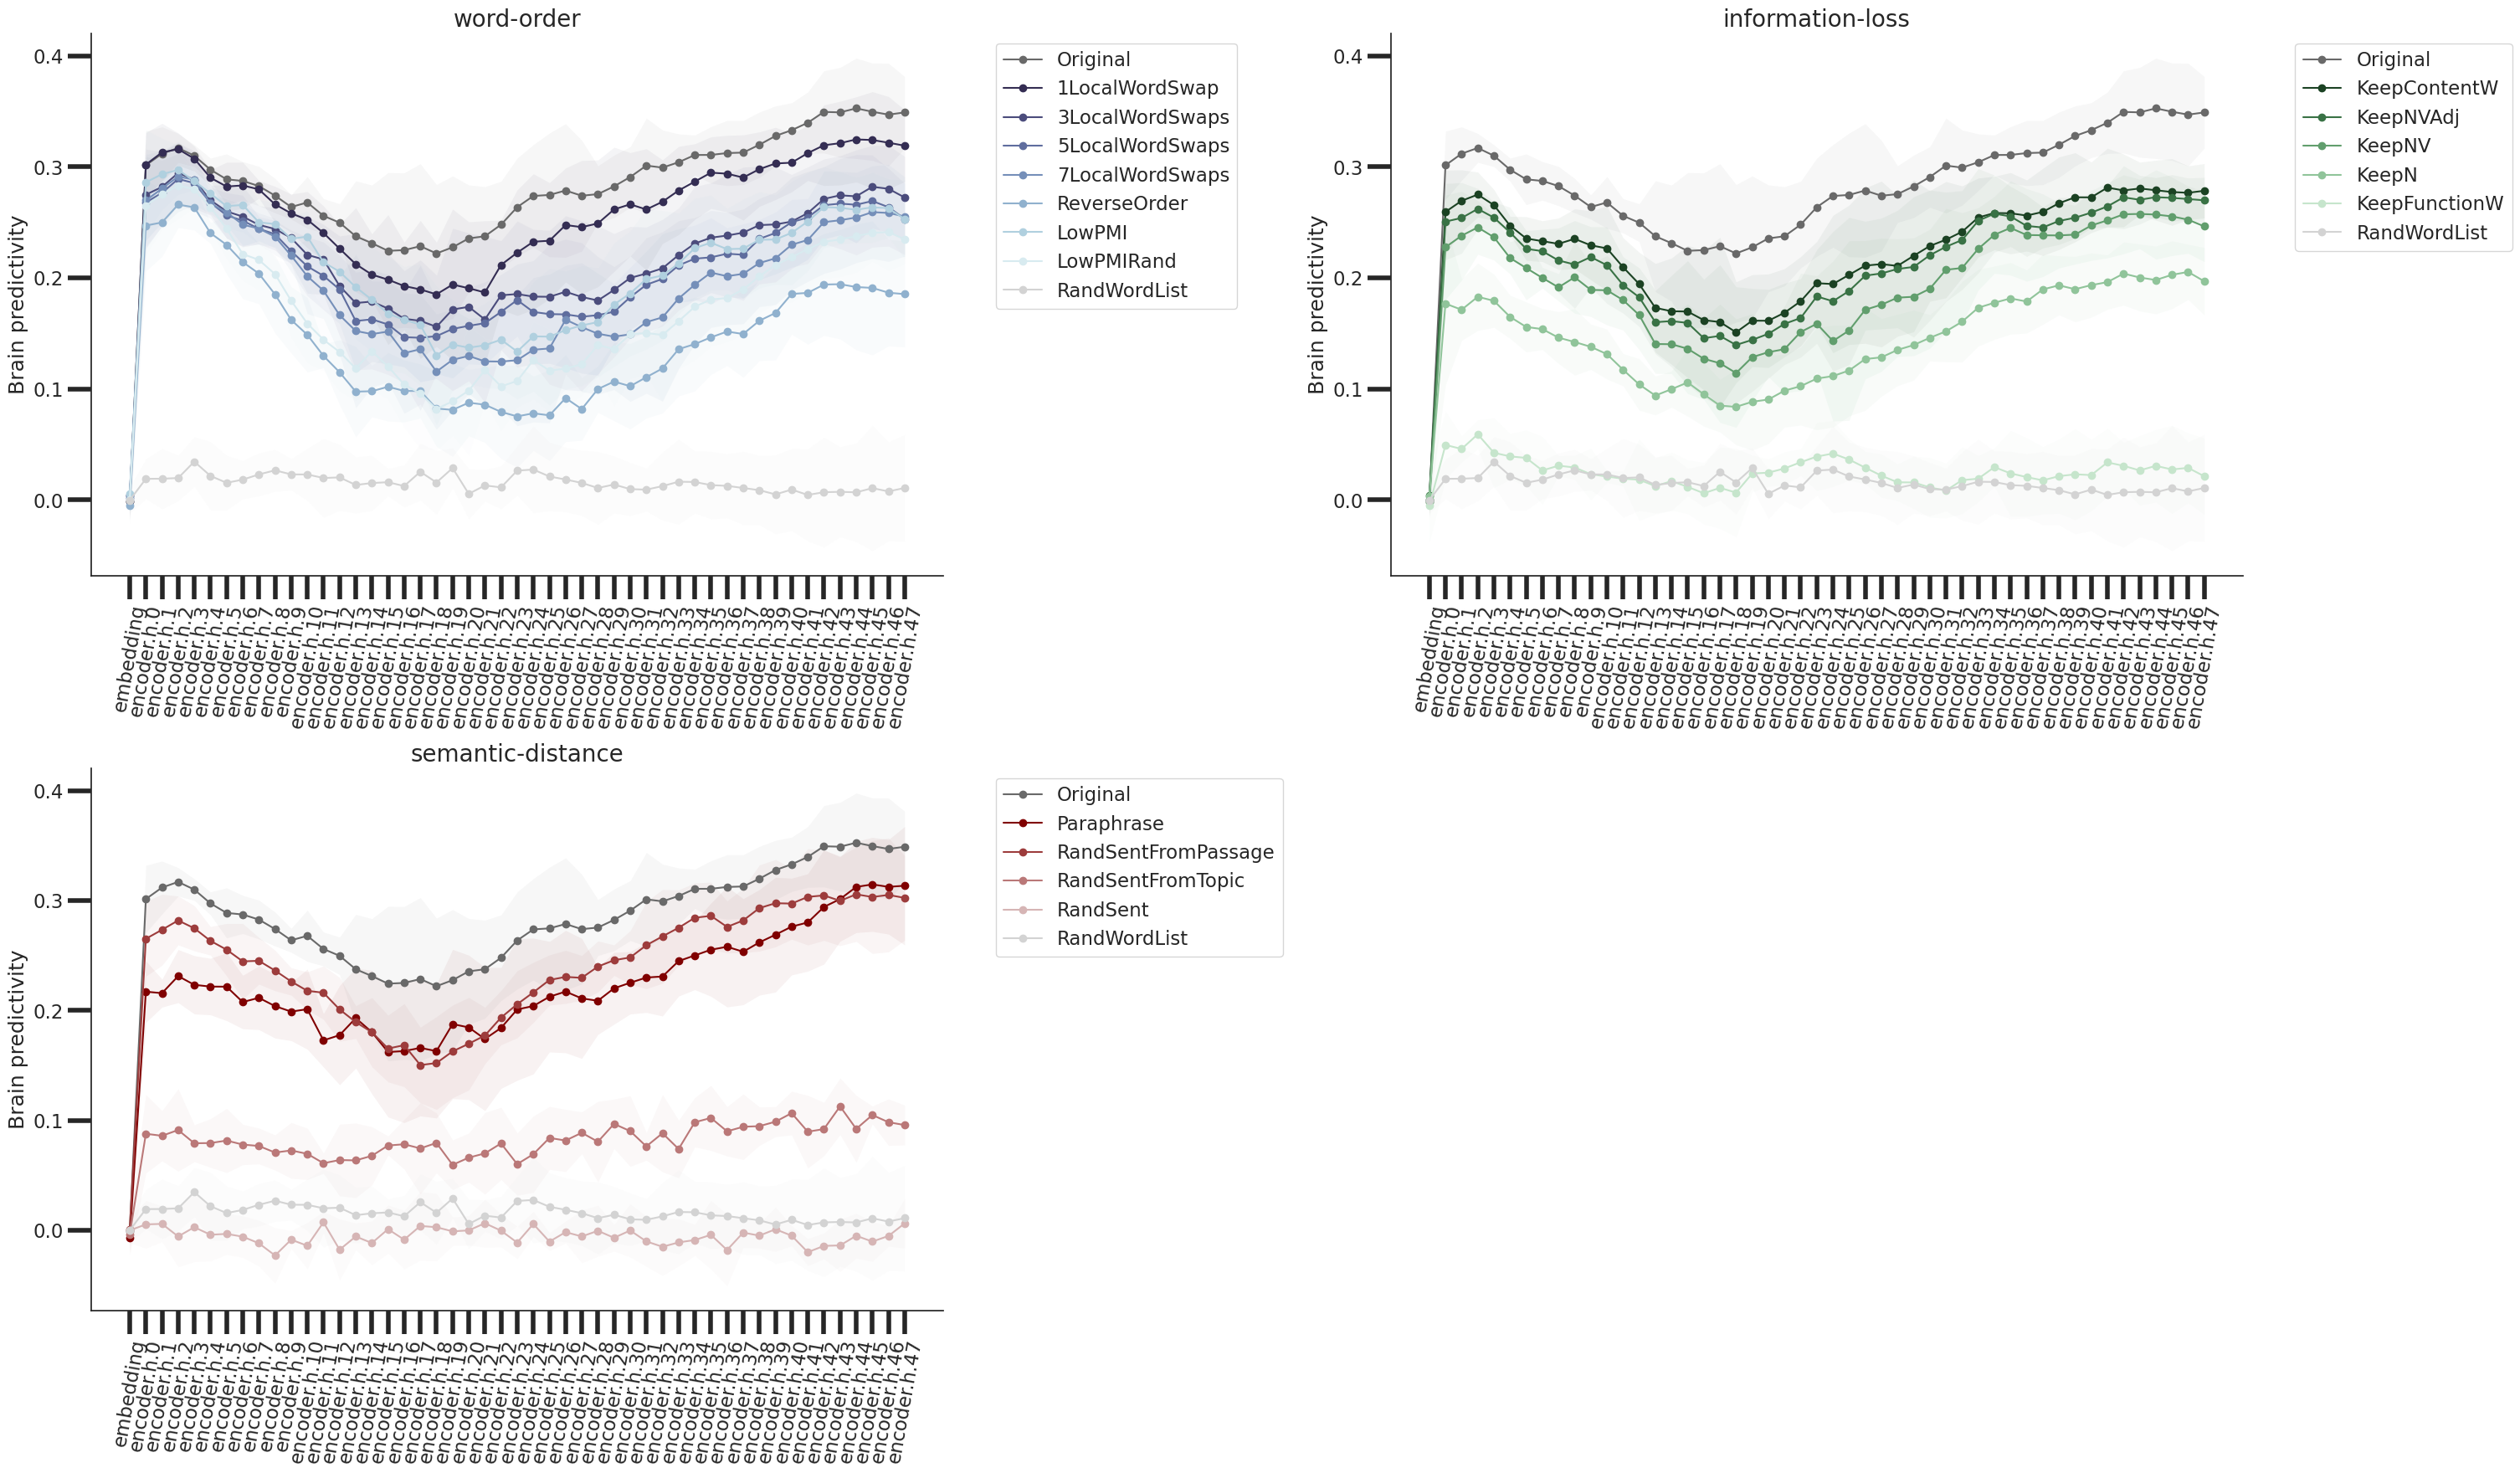

In [42]:
get_lineplots_loop(error_shading=True)